# To do:

 - Both
     - Figure out how to signal injuries
 - Mins
     - Work on those cases where role players get an increase in playtime
     - Create foul trouble signal feature
     - Work with Szn_Wins and OppSzn_Wins

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import os

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")

cwd = os.path.abspath(os.getcwd()).replace("\\", "/")
if cwd.startswith("C:/Users/Rodolfo/"):
    RUN_LOCATION = "local"
else:
    RUN_LOCATION = "cloud"
time_offset = {"local": 3, "cloud": -5}
now = str((datetime.now() + timedelta(hours=time_offset[RUN_LOCATION]) + timedelta(hours=-3)).date())
print(f"Today's date:", now)

tgt_stat = "PTS"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-05
Target Stat: PTS


In [2]:
%run ./common_utils.ipynb

# ML Functions

In [3]:
def feature_importance(model, all_features):
    # Get gain importance
    importance = model.get_score(importance_type='gain')
    
    # Fill in 0 for missing features
    df_importance = pd.DataFrame({
        'feature': all_features,
        'importance': [importance.get(f, 0) for f in all_features]
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    if df_importance.shape[0] >= 50:
        with pd.option_context('display.max_rows', None):
            display(df_importance)
    else:
        display(df_importance)
    
    xgb.plot_importance(model)
    plt.show()

In [4]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            'starter', 'bench', 'reserve'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [5]:
def hyperparam_tuning(DFS, pred_col, n_iter=20, early_stopping_rounds=50):
    """
    Hyperparameter tuning using native XGBoost API and DMatrix,
    with early stopping support (compatible with XGBoost 3.1.2)
    """

    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert datasets to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.01, 0.05),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(1, 8),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 2)
    }

    # Sample n_iter random parameter combinations
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k, v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_mae = float('inf')
    best_params = None
    best_bst = None

    # Manual hyperparameter search
    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')
        params.update({
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "device": "cuda",
            "seed": 42
        })
        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        # Predict on validation set to compute MAE
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        mae = mean_absolute_error(y_val, val_preds)
        print(f"Validation MAE: {mae:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_params = params.copy()
            best_bst = bst

    print("\nBest validation MAE:", best_mae)
    print("Best parameters:", best_params)

    # Predict on test set using best model
    preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    test_df[pred_col] = y_test
    test_df[f'{pred_col}_preds'] = preds
    test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
    test_df['Opp'] = team_encoder.inverse_transform(test_df["Opp"])
    test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])
    test_df['Pos'] = position_encoder.inverse_transform(test_df["Pos"])
    analyze_df = test_df[['Date', 'Team', 'Player', 'Pos', 'Opp', pred_col, f'{pred_col}_preds']]
    print("\nTest Metrics:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    return best_bst, preds, y_test, analyze_df

### Create Base df

In [106]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
for i in [2021, 2022, 2023, 2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_stats.csv")
    df_actuals['Season'] = i
    df = pd.concat([df, df_actuals])

    df_schd = pd.read_csv(f"../tables/{i}/nba_schedule.csv")
    df_schd['Season'] = i
    df2 = pd.concat([df2, df_schd])
    
    df_gms = pd.read_csv(f"../tables/{i}/season_gamelogs.csv")
    df_gms['Season'] = i
    df3 = pd.concat([df3, df_gms])
    
    df_inj = pd.read_csv(f"../tables/{i}/injuries.csv")
    df_inj['Season'] = i
    df4 = pd.concat([df4, df_inj])

df['Date'] = pd.to_datetime(df.Date)
df2['Date'] = pd.to_datetime(df2.Date)
df3['Date'] = pd.to_datetime(df3.Date)
df3 = df3[~df3[['Date', 'Team', 'Player']].duplicated(keep='last')]
df4['Date'] = pd.to_datetime(df4.Date)

df3 = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
df3['PR'] = df3.PTS + df3.REB 
df3['PA'] = df3.PTS + df3.AST
df3['RA'] = df3.REB + df3.AST
df3['PRA'] = df3.PTS + df3.REB + df3.AST
df3['STL_BLK'] = df3.STL + df3.BLK
df = df.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='left')

df_mtch = df2[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Season', 'Date', 'Team', 'Team_type', 'AwayPTS', 'HomePTS', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch = df_mtch.sort_values(["Team", "Date"])
df_mtch['team_game_num'] = df_mtch.groupby(["Team", "Season"]).cumcount() + 1
df_mtch['Spread'] = np.where(df_mtch.Team_type == 'Home', df_mtch.HomePTS - df_mtch.AwayPTS, df_mtch.AwayPTS - df_mtch.HomePTS)
df_mtch['Total'] = df_mtch.AwayPTS + df_mtch.HomePTS
df_mtch['is_Win'] = np.where(df_mtch.Spread > 0, 1, 0)
df_mtch['Szn_Wins'] = df_mtch.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.drop(['Season', 'Team_type'], axis=1).merge(df_mtch, on=['Date', 'Team'])

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()
position_encoder = LabelEncoder()
status_encoder = LabelEncoder()

# Encode string cols
team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
df["Team"] = team_encoder.transform(df["Team"])
df["Opp"] = team_encoder.transform(df["Opp"])
df["Player_name"] = df.Player
df["Player"] = player_encoder.fit_transform(df["Player"])
df["Pos"] = position_encoder.fit_transform(df["Pos"])
df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
df["Status"] = status_encoder.fit_transform(df["Status"])
df_pred = df.copy()
df = df[(df.Active == 1) & (df.MP > 0)].sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
print('base df created', datetime.now())

base df created 2026-01-05 19:14:05.880933


In [7]:
# df3_temp = df3.copy().drop('Season', axis=1)
# df4_temp = df4.copy().drop('Season', axis=1)
# # display(df3_temp[(df3_temp.Date == '2025-12-25') & (df3_temp.game_id == '20251225_CLE_NYK')])
# df_temp = df4_temp.merge(df3_temp, on=['Date', 'Team', 'Player'], how='outer')
# df_temp['game_id'] = np.where(df_temp.game_id.isnull(), )

# df_temp = df_temp[(df_temp.Date == '2025-12-25') & (df_temp.Team.isin(['CLE', 'NYK']))]
# display(df_temp)

# Minutes Projection Model

In [58]:
def setup_df_mins(con, df):
    
    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'B2B', 'MP',
             'Spread', 'Total', 'team_game_num', 'Szn_Wins', 'pstszn_gm', 'is_OT']]
    
    for col in ['MP']:
        for N in [1, 3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )

    games_last_7_days = df.sort_values(['Player', 'Season', 'Date']).groupby(['Player', 'Season']).rolling('7D', on='Date', closed='left')['MP'].count().reset_index().rename(columns={"MP": "gms_L7_days"})
    games_last_7_days = games_last_7_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_7_days, on=['Player', 'Season', 'Date'])
    df['gms_L7_days'] = df.gms_L7_days.fillna(0).astype(int)
    
    df['prev_team_mins_pct'] = (df.groupby(['Player', 'Season'])['MP'].shift(1)) / 240
           
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
    
    for N in [1, 3, 5]:
        for role in ['reserve_td', 'bench_td', 'starter_td']:
            df[f'{role}_last{N}'] = (
                df.sort_values(['Player', 'Date']).groupby('Player')[role]
                  .rolling(N, min_periods=1)
                  .sum()
                  .shift(1)
                  .reset_index(0, drop=True)
            )
        rec_role_cols = [f'{role}_last{N}' for role in ['reserve_td', 'bench_td', 'starter_td']]
        df[f'recent_most_common_role_L{N}'] = df[rec_role_cols].idxmax(axis=1)
        df[f'recent_role_L{N}'] = 0
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'starter_td_last{N}', 1, df[f'recent_role_L{N}'])
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'bench_td_last{N}', 2, df[f'recent_role_L{N}'])
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'reserve_td_last{N}', 3, df[f'recent_role_L{N}'])      
        df = df.drop(f'recent_most_common_role_L{N}', axis=1)
        for role in ['reserve_td', 'bench_td', 'starter_td']:
            df = df.drop(f'{role}_last{N}', axis=1)
      
    df['missed_games'] = (
        df.groupby(['Player', 'Team', 'Season'])['team_game_num']      
          .diff()
          .sub(1)
          .fillna(0)
          .astype(int)
    )
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread < 6), 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread >= 6) & abs(df.Spread <= 14)), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread > 14), 3, df.game_spread_type) 
    
    df['missed_games_after'] = (
        df.groupby(['Player', 'Team', 'Season'])['team_game_num']
          .diff(-1)
          .abs()
          .sub(1)
          .fillna(0)
          .astype(int)
    )
    df['MP_diff_next_avg5'] = df.groupby('Player')['MP'].shift(-1) - df['MP_L5_avg']
    df['Injured'] = (
                        ((df.missed_games_after > 0) & (df.MP_diff_next_avg5 < -10) & (df.role == 1)) | 
                        ((df.missed_games_after > 0) & (df.MP_diff_next_avg5 < -5) & (df.role == 2))
                    ).astype(int)
    
    df['return_game'] = (df.groupby('Player')['Injured'].shift(1) == 1).astype(int)
    df['games_since_return'] = (df.groupby('Player')['return_game'].cumsum())
    df['games_since_return'] = (df.groupby(['Player', 'games_since_return']).cumcount())
    df['ramp_phase'] = 0
    df.loc[df.return_game == 1, 'ramp_phase'] = 1
    df.loc[df.games_since_return.isin([1, 2]), 'ramp_phase'] = 2
    df.loc[df.games_since_return >= 3, 'ramp_phase'] = 3
    df['starter_return'] = ((df.return_game == 1) & (df.role == 1)).astype(int)
    df['bench_return']   = ((df.return_game == 1) & (df.role == 2)).astype(int)
    
    df['MP_drop_pct_L5'] = (df.MP_L5_avg - df.MP) / df.MP_L5_avg
    df['Early_stop'] = (
        (df['MP'] < 5) |
        ((df.role == 1) & (df.MP_drop_pct_L5 >= 0.35)) |   # starters
        ((df.role == 2) & (df.MP_drop_pct_L5 >= 0.45)) |   # bench
        ((df.role == 3) & (df.MP_drop_pct_L5 >= 0.55))     # reserve
    ).astype(int)
    
    for N in [1, 3, 5]:
        df[f'Early_stop_L{N}'] = df.sort_values(['Player', 'Date'])['Early_stop'].shift(1).rolling(N).sum()
        df[f'Injured_L{N}'] = df.sort_values(['Player', 'Date'])['Injured'].shift(1).rolling(N).sum()
    
    # Location based features
    df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
    df['Location'] = df.apply(lambda r: r['Team'] if r['Team_type'] == 'Home' else r['Opp'], axis=1)
    df['PrevLocation'] = df.groupby('Player')['Location'].shift(1)
    df['same_arena'] = (df['PrevLocation'] == df['Location']).astype(int)

    df = df.drop(['Season', 'Team_type', 'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter', 'MP_drop_pct_L5',
                  'PrevLocation', 'Location', 'Injured', 'missed_games_after', 'MP_diff_next_avg5', 'return_game'], axis=1)    
    
    return df

,Date,Team,Opp,Player,Pos,B2B,MP,Spread,Total,team_game_num,Szn_Wins,pstszn_gm,is_OT,MP_L1_avg,MP_L3_avg,MP_L5_avg,MP_L10_avg,gms_L7_days,prev_team_mins_pct,role,recent_role_L1,recent_role_L3,recent_role_L5,missed_games,game_spread_type,games_since_return,ramp_phase,starter_return,bench_return,Early_stop,Early_stop_L1,Injured_L1,Early_stop_L3,Injured_L3,Early_stop_L5,Injured_L5,DaysLstGm,same_arena
0,2021-10-19,2,16,71,0,0,22.98,-23.0,231.0,1,0,0,0,2.33,5.410000,3.964,6.374000,0,NaN,2,3,3,3,0,1,0,0,0,0,0,1.0,0.0,2.0,0.0,4.0,0.0,0,0
1,2021-10-19,2,16,96,3,0,3.75,-23.0,231.0,1,0,0,0,12.55,18.450000,24.864,21.474000,0,NaN,1,2,2,2,0,1,0,0,0,0,1,1.0,0.0,1.0,0.0,1.0,0.0,0,0
2,2021-10-19,2,16,112,4,0,3.75,-23.0,231.0,1,0,0,0,34.03,23.060000,24.296,28.092000,0,NaN,2,1,2,1,0,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,2021-10-19,2,16,211,3,0,3.75,-23.0,231.0,1,0,0,0,12.33,11.650000,11.650,11.650000,0,NaN,2,2,2,3,0,1,0,0,0,0,1,0.0,0.0,1.0,0.0,2.0,0.0,0,0
4,2021-10-19,2,16,406,2,0,30.63,-23.0,231.0,1,0,0,0,2.78,4.620000,8.382,7.942857,0,NaN,1,3,3,3,0,1,0,0,0,0,0,1.0,0.0,2.0,0.0,2.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112659,2026-01-04,29,17,568,3,1,17.85,-26.0,256.0,34,9,0,0,22.83,22.686667,21.848,24.500000,3,0.095125,2,2,2,2,0,1,5,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
112660,2026-01-04,29,17,620,4,1,7.03,-26.0,256.0,34,9,0,0,19.60,11.090000,11.012,9.572000,2,0.081667,3,2,2,2,2,1,106,3,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,6,0
112661,2026-01-04,29,17,646,1,1,13.75,-26.0,256.0,34,9,0,0,16.87,19.530000,20.384,22.883000,4,0.070292,2,2,2,2,0,1,68,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
112662,2026-01-04,29,17,881,4,1,26.97,-26.0,256.0,34,9,0,0,28.00,27.163333,25.328,23.471000,4,0.116667,1,1,1,1,0,1,26,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0



Trial 1/5: {'n_estimators': 343, 'learning_rate': np.float64(0.015187482072700296), 'max_depth': 5, 'min_child_weight': 3, 'subsample': np.float64(0.930929016052349), 'colsample_bytree': np.float64(0.7723927566076347), 'gamma': np.float64(0.9267710492219163), 'reg_lambda': np.float64(4.057005115423528), 'reg_alpha': np.float64(0.7450489975276584)}
Validation MAE: 3.8662

Trial 2/5: {'n_estimators': 1165, 'learning_rate': np.float64(0.017152995719021655), 'max_depth': 4, 'min_child_weight': 4, 'subsample': np.float64(0.9043194485548424), 'colsample_bytree': np.float64(0.8362087031025913), 'gamma': np.float64(0.34375527673532136), 'reg_lambda': np.float64(4.471025667372848), 'reg_alpha': np.float64(1.971490529412973)}
Validation MAE: 3.8426

Trial 3/5: {'n_estimators': 1145, 'learning_rate': np.float64(0.03878258938403573), 'max_depth': 5, 'min_child_weight': 1, 'subsample': np.float64(0.9586729564767438), 'colsample_bytree': np.float64(0.746962322167246), 'gamma': np.float64(0.99340617

,feature,importance,pct
0,Early_stop,49476.820312,0.358338
1,MP_L5_avg,30437.708984,0.578785
2,MP_L10_avg,20449.914062,0.726895
3,role,9346.109375,0.794584
4,MP_L3_avg,7160.110840,0.846442
5,Injured_L1,2732.791260,0.866234
6,is_OT,2479.077148,0.884189
7,pstszn_gm,1946.148682,0.898284
8,prev_team_mins_pct,1920.708008,0.912195
9,game_spread_type,1562.623047,0.923512


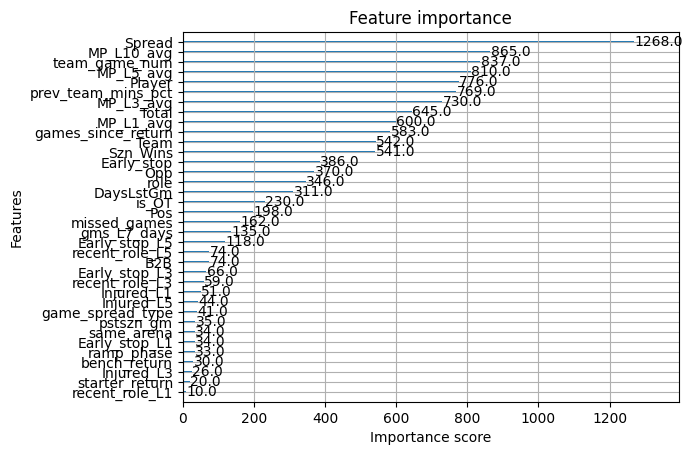

In [59]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

n = len(df_mins)
train_end = int(0.8 * n)
val_end   = int(0.9 * n)
mins_train_df = df_mins.iloc[:train_end]
mins_val_df   = df_mins.iloc[train_end:val_end]
mins_test_df  = df_mins.iloc[val_end:]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# mins_model = create_baseline_model(df_mins, "MP", mins_DFS)
mins_model, mins_preds, y_test_mins, analyze_df_mins = hyperparam_tuning(mins_DFS, "MP", n_iter=1)
feature_importance(mins_model, df_mins.columns.tolist())

# mins_model.save_model("../ML_models/mins_model.json")
# print('Saved minutes model!')

,Date,Team,Opp,Player,Pos,B2B,Spread,Total,team_game_num,Szn_Wins,pstszn_gm,is_OT,MP_L1_avg,MP_L3_avg,MP_L5_avg,MP_L10_avg,gms_L7_days,prev_team_mins_pct,role,recent_role_L1,recent_role_L3,recent_role_L5,missed_games,game_spread_type,games_since_return,ramp_phase,starter_return,bench_return,Early_stop,Early_stop_L1,Injured_L1,Early_stop_L3,Injured_L3,Early_stop_L5,Injured_L5,DaysLstGm,same_arena,MP,MP_preds,Diff,Diff2
5356,2025-11-20,PHI,MIL,VJ Edgecombe,SG,1,9.0,237.0,15,9,0,1,37.10,37.290000,35.640,36.125,3,0.154583,1,1,1,1,0,2,14,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,38.22,41.431129,-3.211129,3.211129
6753,2025-11-30,PHI,ATL,VJ Edgecombe,SG,0,-8.0,276.0,19,10,0,2,38.22,37.546667,36.948,35.974,0,0.159250,1,1,1,1,3,1,0,1,1,0,1,0.0,1.0,0.0,1.0,0.0,1.0,10,0,21.42,18.155130,3.264870,3.264870
7052,2025-12-02,PHI,WAS,VJ Edgecombe,SG,1,19.0,223.0,20,11,0,0,21.42,32.246667,34.302,34.831,1,0.089250,1,2,1,1,0,3,1,2,0,0,0,1.0,0.0,1.0,1.0,1.0,1.0,2,0,23.72,30.078598,-6.358598,6.358598
7330,2025-12-04,PHI,GSW,VJ Edgecombe,SG,0,1.0,197.0,21,12,0,0,23.72,27.786667,31.556,33.431,2,0.098833,1,2,2,1,0,1,2,2,0,0,0,0.0,0.0,1.0,1.0,1.0,1.0,2,0,23.85,32.966381,-9.116381,9.116381
7546,2025-12-05,PHI,MIL,VJ Edgecombe,SG,1,15.0,217.0,22,13,0,0,23.85,22.996667,28.862,32.094,3,0.099375,1,2,2,2,0,3,3,3,0,0,0,0.0,0.0,1.0,0.0,1.0,1.0,1,0,24.43,30.178154,-5.748154,5.748154
7840,2025-12-07,PHI,LAL,VJ Edgecombe,SG,0,-4.0,220.0,23,13,0,0,24.43,24.000000,26.328,30.984,4,0.101792,1,2,2,2,0,1,4,3,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,2,0,37.82,30.824223,6.995777,6.995777


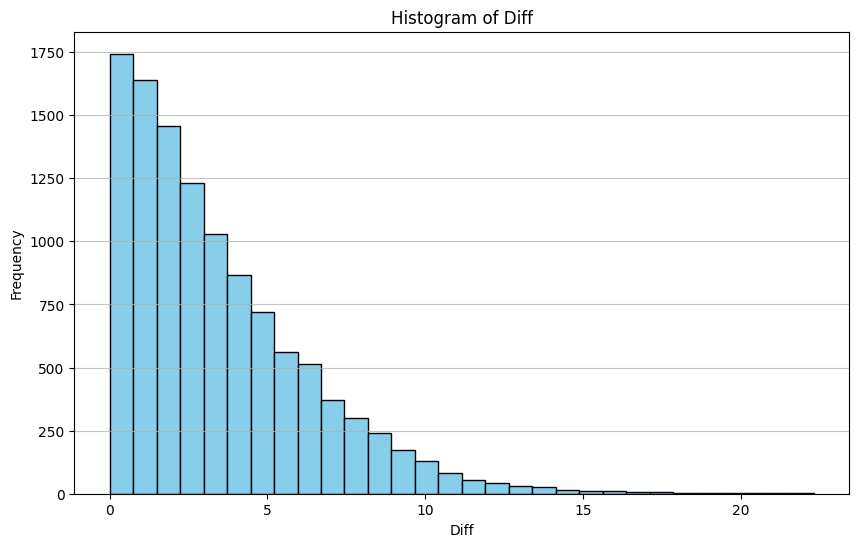

In [55]:
analyze_df_mins = mins_test_df.drop(['MP', 'MP_preds'], axis=1)\
                .merge(analyze_df_mins[['Date', 'Team', 'Player', 'MP', 'MP_preds']], on=['Date', 'Team', 'Player'])
analyze_df_mins['Diff'] = analyze_df_mins['MP'] - analyze_df_mins[f'MP_preds']
analyze_df_mins['Diff2'] = abs(analyze_df_mins['Diff'])
analyze_df_mins.sort_values('Diff2', ascending=False).drop('Diff2', axis=1).head(15)
display(analyze_df_mins[(analyze_df_mins.Date.isin(['2025-11-20', '2025-11-30', '2025-12-02', '2025-12-04', '2025-12-05', '2025-12-07'])) & (analyze_df_mins.Player == 'VJ Edgecombe')])
# display(analyze_df_mins[(analyze_df_mins.Diff < -15)])

plt.figure(figsize=(10,6))
plt.hist(analyze_df_mins['Diff2'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Diff')
plt.xlabel('Diff')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [131]:
rmse = np.sqrt(mean_squared_error(y_test_mins, mins_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_mins, mins_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', 'MP_L5_avg']][df_yesterday.MP > 0]

df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff'] <= rmse, 1, 0)

print("\nYesterday's Results:")
print("Total Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), '/', df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff'], axis=1)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

RMSE: 4.5088402572451365

Yesterday's Results:
Total Accuracy (InRMSE_Range): 0.6593406593406593
60 / 91


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
0,2026-01-04,CLE,Sam Merrill,SG,DET,23.550919,27.25,26.418029,1
13,2026-01-04,CLE,Evan Mobley,PF,DET,31.198790,32.75,29.981841,1
40,2026-01-04,CLE,De'Andre Hunter,SF,DET,26.888300,24.10,26.372499,1
45,2026-01-04,CLE,Jaylon Tyson,SG,DET,27.216845,25.27,27.896196,1
51,2026-01-04,CLE,Donovan Mitchell,SG,DET,34.247589,33.08,32.995182,1
79,2026-01-04,CLE,Darius Garland,PG,DET,32.487499,32.13,31.767260,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
1,2026-01-04,MIL,Giannis Antetokounmpo,PF,SAC,28.480701,31.62,28.829730,1
4,2026-01-04,MIL,Myles Turner,C,SAC,27.853252,31.92,27.893523,1
26,2026-01-04,MIL,Kevin Porter Jr.,PG,SAC,36.455505,39.73,35.636871,1
61,2026-01-04,MIL,Ryan Rollins,PG,SAC,31.941858,33.87,29.359307,1
70,2026-01-04,MIL,Bobby Portis,PF,SAC,23.641373,16.08,26.425074,0
86,2026-01-04,MIL,Kyle Kuzma,PF,SAC,29.801361,17.72,29.057417,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
2,2026-01-04,DEN,Christian Braun,SG,BRK,27.538017,24.20,28.551500,1
43,2026-01-04,DEN,Aaron Gordon,PF,BRK,23.628725,21.23,29.773669,1
63,2026-01-04,DEN,Jamal Murray,PG,BRK,36.312431,39.73,35.845502,1
68,2026-01-04,DEN,Peyton Watson,SF,BRK,32.882156,28.62,29.982040,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
3,2026-01-04,SAC,Zach LaVine,SG,MIL,28.486666,35.53,29.404528,0
54,2026-01-04,SAC,Keegan Murray,PF,MIL,34.168648,26.72,34.698530,0
69,2026-01-04,SAC,Russell Westbrook,PG,MIL,28.383686,37.90,29.013702,0
83,2026-01-04,SAC,DeMar DeRozan,PF,MIL,34.672501,28.72,30.929404,0
87,2026-01-04,SAC,Maxime Raynaud,C,MIL,28.879982,24.13,26.475719,0
92,2026-01-04,SAC,Dennis Schroder,PG,MIL,26.608156,26.12,25.601045,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
5,2026-01-04,MIN,Naz Reid,C,WAS,27.860161,20.12,28.888048,0
24,2026-01-04,MIN,Anthony Edwards,SG,WAS,35.905300,30.17,35.367970,0
32,2026-01-04,MIN,Donte DiVincenzo,SG,WAS,30.702559,22.58,31.037349,0
35,2026-01-04,MIN,Jaden McDaniels,PF,WAS,30.098097,21.88,30.721181,0
50,2026-01-04,MIN,Rudy Gobert,C,WAS,31.641565,29.32,31.128673,1
60,2026-01-04,MIN,Julius Randle,PF,WAS,34.265678,25.30,32.694957,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
6,2026-01-04,LAL,Luka Doncic,PG,MEM,35.530140,38.88,32.367308,1
34,2026-01-04,LAL,LeBron James,SF,MEM,33.629990,37.28,31.058966,1
38,2026-01-04,LAL,Deandre Ayton,C,MEM,28.420122,33.57,27.177446,0
62,2026-01-04,LAL,Marcus Smart,SG,MEM,29.761141,31.15,25.773956,1
64,2026-01-04,LAL,Jarred Vanderbilt,PF,MEM,20.961756,21.95,20.355976,1
67,2026-01-04,LAL,Jaxson Hayes,C,MEM,18.542831,14.43,16.289256,1
77,2026-01-04,LAL,Jake LaRavia,PF,MEM,30.311096,34.50,26.334244,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
7,2026-01-04,ORL,Anthony Black,PG,IND,34.568218,35.55,34.458659,1
10,2026-01-04,ORL,Paolo Banchero,PF,IND,36.149956,36.15,34.159427,1
20,2026-01-04,ORL,Desmond Bane,SG,IND,34.898941,36.55,35.254938,1
75,2026-01-04,ORL,Wendell Carter Jr.,C,IND,31.493427,31.52,31.640240,1
82,2026-01-04,ORL,Goga Bitadze,C,IND,16.001284,16.48,16.041726,1
90,2026-01-04,ORL,Tyus Jones,PG,IND,20.738050,13.92,23.592847,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
8,2026-01-04,BRK,Day'Ron Sharpe,C,DEN,19.745663,32.10,16.878646,0
33,2026-01-04,BRK,Noah Clowney,PF,DEN,29.960150,29.12,28.899792,1
72,2026-01-04,BRK,Terance Mann,SG,DEN,26.127554,26.03,26.598918,1
74,2026-01-04,BRK,Michael Porter Jr.,SF,DEN,31.644651,32.07,32.302234,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
9,2026-01-04,MEM,Jaren Jackson Jr.,C,LAL,33.197258,33.68,31.633083,1
11,2026-01-04,MEM,Cedric Coward,SG,LAL,27.743280,12.55,27.678212,0
25,2026-01-04,MEM,Santi Aldama,PF,LAL,33.054234,30.73,32.320333,1
37,2026-01-04,MEM,Jaylen Wells,SG,LAL,30.453861,24.50,31.675684,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
12,2026-01-04,DET,Paul Reed,C,CLE,7.860435,30.13,6.906667,0
15,2026-01-04,DET,Duncan Robinson,SF,CLE,26.208231,29.52,27.041323,1
18,2026-01-04,DET,Marcus Sasser,PG,CLE,12.129115,3.00,7.972752,0
21,2026-01-04,DET,Isaiah Stewart,C,CLE,24.026945,31.47,22.598524,0
29,2026-01-04,DET,Jaden Ivey,SG,CLE,19.048105,19.23,16.251936,1
30,2026-01-04,DET,Ausar Thompson,SF,CLE,27.259537,21.72,26.778057,0
58,2026-01-04,DET,Javonte Green,SG,CLE,21.515100,24.02,18.080016,1
59,2026-01-04,DET,Cade Cunningham,PG,CLE,35.431683,37.03,34.376925,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
14,2026-01-04,MIA,Bam Adebayo,C,NOP,32.584702,28.78,30.225278,1
31,2026-01-04,MIA,Kel'el Ware,C,NOP,28.454071,24.63,26.183129,1
52,2026-01-04,MIA,Andrew Wiggins,SF,NOP,32.401409,28.35,30.546752,1
71,2026-01-04,MIA,Davion Mitchell,PG,NOP,31.737719,29.32,27.887386,1
78,2026-01-04,MIA,Norman Powell,SG,NOP,32.088047,28.78,30.881419,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
16,2026-01-04,PHO,Collin Gillespie,PG,OKC,30.880175,25.87,31.632794,0
27,2026-01-04,PHO,Devin Booker,SG,OKC,31.549294,38.18,31.842391,0
44,2026-01-04,PHO,Mark Williams,C,OKC,22.033995,21.28,23.539705,1
65,2026-01-04,PHO,Oso Ighodaro,PF,OKC,22.144987,23.63,23.317867,1
66,2026-01-04,PHO,Royce O'Neale,SF,OKC,29.493750,31.52,28.139116,1
91,2026-01-04,PHO,Dillon Brooks,SF,OKC,30.011669,33.55,29.754482,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
17,2026-01-04,NOP,Jordan Poole,PG,MIA,27.910013,24.60,27.161991,1
19,2026-01-04,NOP,Zion Williamson,PF,MIA,30.150599,26.22,28.245887,1
46,2026-01-04,NOP,Jeremiah Fears,PG,MIA,27.707008,26.12,26.660222,1
47,2026-01-04,NOP,Derik Queen,C,MIA,24.684788,29.62,29.352802,0
53,2026-01-04,NOP,Trey Murphy III,SF,MIA,29.734610,38.20,34.605384,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
22,2026-01-04,OKC,Jalen Williams,SG,PHO,28.511902,34.48,28.316282,0
23,2026-01-04,OKC,Chet Holmgren,PF,PHO,29.873045,32.60,27.023697,1
42,2026-01-04,OKC,Shai Gilgeous-Alexander,PG,PHO,33.915668,35.65,30.848370,1
48,2026-01-04,OKC,Cason Wallace,SG,PHO,26.628942,17.85,25.714904,0
56,2026-01-04,OKC,Ajay Mitchell,SG,PHO,26.103598,27.20,24.658169,1
84,2026-01-04,OKC,Luguentz Dort,SF,PHO,27.252378,26.52,25.669445,1
89,2026-01-04,OKC,Aaron Wiggins,SG,PHO,21.226280,19.28,14.174378,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
36,2026-01-04,IND,Andrew Nembhard,PG,ORL,33.359459,35.48,31.777865,1
39,2026-01-04,IND,Aaron Nesmith,SF,ORL,29.206600,34.13,24.039442,0
49,2026-01-04,IND,Ben Sheppard,SG,ORL,20.102419,24.35,21.708561,1
81,2026-01-04,IND,Pascal Siakam,PF,ORL,33.805614,36.45,31.711855,1
85,2026-01-04,IND,Jay Huff,C,ORL,18.345234,17.23,20.914304,1
88,2026-01-04,IND,T.J. McConnell,PG,ORL,17.348101,20.80,15.957269,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_L5_avg,InRMSE_Range
41,2026-01-04,WAS,Bilal Coulibaly,SG,MIN,28.367390,27.57,26.788715,1
55,2026-01-04,WAS,Tre Johnson,SG,MIN,24.575035,26.97,21.721966,1
57,2026-01-04,WAS,Justin Champagnie,SF,MIN,24.012918,18.15,22.886698,0
76,2026-01-04,WAS,CJ McCollum,SG,MIN,31.834545,22.17,31.846917,0
80,2026-01-04,WAS,Khris Middleton,SF,MIN,22.410961,17.85,21.819302,0


# Main Model

In [128]:
def setup_df_main(df):
    
    # Stat dependent features 
    if tgt_stat == 'PTS':
        tgt_stat_cols = ['TPM', 'FG', 'FT', 'TPA', 'FGA', 'FTA']
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 'team_game_num', 
         'PTS', 'TPM', 'FG', 'FGA', 'TPA', 'FT', 'FTA', 
         f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
         f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]
        
        # Efficiency metrics
        df['three_rate_raw'] =  np.where(df.FGA > 0, df['TPA'] / df['FGA'], 0)
        df['ft_rate_raw']    =  np.where(df.FGA > 0, df['FTA'] / df['FGA'], 0)
        df['eFG_raw'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
        df['TS_raw'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))    
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        
        for w in [3, 5, 10]:
            for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
                col = f"{metric}_L{w}"
                df[col] = (
                    df.groupby(['Player','Season'])[f'{metric}_raw']
                      .rolling(w, min_periods=1)
                      .mean()
                      .shift(1)
                      .reset_index(level=[0,1], drop=True)
                )
        for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
            col = f'{metric}_weighted'
            df[col] = (
                0.6 * df[f'{metric}_L3'] +
                0.3 * df[f'{metric}_L5'] +
                0.1 * df[f'{metric}_L10']
            )
            df = df.drop(f'{metric}_raw', axis=1)
        
    elif tgt_stat == 'PRA':
        tgt_stat_cols = ['PTS', 'REB', 'AST', 'TPM', 'FG']
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 'team_game_num', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK', 
         'FG', 'FGA', 'TPA', 'FT', 'FTA', 
         f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
         f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]
        
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        for w in [3, 5, 10]:
            df[f"usage_proxy_L{w}"] = (
                df.groupby(['Player','Season'])[f'usage_proxy_raw']
                  .rolling(w, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0,1], drop=True)
            )
        df['usage_proxy_weighted'] = (
            0.6 * df[f'usage_proxy_L3'] +
            0.3 * df[f'usage_proxy_L5'] +
            0.1 * df[f'usage_proxy_L10']
        )
        df = df.drop('usage_proxy_raw', axis=1)
        
        
    else:
        tgt_stat_cols = []
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 'team_game_num', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK',
         'FG', 'FGA', 'TPA', 'FT', 'FTA', 
          f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
          f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]

    
    # Create rolling + lag features    
    for col in ['MP'] + tgt_stat_cols:
        df[f'{col}_lst_gm'] = (
            df
            .groupby(['Player', 'Season'])[col]
            .shift(1)
        )
        for N in [1, 3, 5]:
            df[f'{col}_L{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )

    # Role identifiers features
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
    
    for N in [1, 3, 5]:
        for role in ['reserve_td', 'bench_td', 'starter_td']:
            df[f'{role}_last{N}'] = (
                df.sort_values(['Player', 'Date']).groupby('Player')[role]
                  .rolling(N, min_periods=1)
                  .sum()
                  .shift(1)
                  .reset_index(0, drop=True)
            )
        rec_role_cols = [f'{role}_last{N}' for role in ['reserve_td', 'bench_td', 'starter_td']]
        df[f'recent_most_common_role_L{N}'] = df[rec_role_cols].idxmax(axis=1)
        df[f'recent_role_L{N}'] = 0
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'starter_td_last{N}', 1, df[f'recent_role_L{N}'])
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'bench_td_last{N}', 2, df[f'recent_role_L{N}'])
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'reserve_td_last{N}', 3, df[f'recent_role_L{N}'])      
        df = df.drop(f'recent_most_common_role_L{N}', axis=1)
        for role in ['reserve_td', 'bench_td', 'starter_td']:
            df = df.drop(f'{role}_last{N}', axis=1)
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread < 6), 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread >= 6) & abs(df.Spread <= 14)), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread > 14), 3, df.game_spread_type) 

    df['MP_drop_pct_L5'] = (df.MP_L5_avg - df.MP) / df.MP_L5_avg
    df['Early_stop'] = (
        (df['MP'] < 5) |
        ((df.role == 1) & (df.MP_drop_pct_L5 >= 0.35)) |   # starters
        ((df.role == 2) & (df.MP_drop_pct_L5 >= 0.45)) |   # bench
        ((df.role == 3) & (df.MP_drop_pct_L5 >= 0.55))     # reserve
    ).astype(int)
    
    
    for col in categories + ['Season', 'FG', 'FGA', 'FT', 'FTA', 'TPM', 'TPA', 'MP_drop_pct_L5', 
                             'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter'] + tgt_stat_cols:
        if col == tgt_stat:
            continue
        if col in df.columns:
            df = df.drop(col, axis=1)
        
    return df

,Date,Team,Opp,Player,Pos,MP,team_game_num,PTS,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,Spread,Total,is_OT,three_rate_L3,ft_rate_L3,eFG_L3,TS_L3,usage_proxy_L3,three_rate_L5,ft_rate_L5,eFG_L5,TS_L5,usage_proxy_L5,three_rate_L10,ft_rate_L10,eFG_L10,TS_L10,usage_proxy_L10,three_rate_weighted,ft_rate_weighted,eFG_weighted,TS_weighted,usage_proxy_weighted,MP_lst_gm,MP_L1_avg,MP_L3_avg,MP_L5_avg,TPM_lst_gm,TPM_L1_avg,TPM_L3_avg,TPM_L5_avg,FG_lst_gm,FG_L1_avg,FG_L3_avg,FG_L5_avg,FT_lst_gm,FT_L1_avg,FT_L3_avg,FT_L5_avg,TPA_lst_gm,TPA_L1_avg,TPA_L3_avg,TPA_L5_avg,FGA_lst_gm,FGA_L1_avg,FGA_L3_avg,FGA_L5_avg,FTA_lst_gm,FTA_L1_avg,FTA_L3_avg,FTA_L5_avg,role,recent_role_L1,recent_role_L3,recent_role_L5,game_spread_type,Early_stop
0,2022-10-18,1,22,19,0,23.10,1,6.0,6.000000,6.000000,6.0,6.0,5.0,8.000000,8.0,8.0,8.0,2.0,9.0,243.0,0,0.242063,0.814815,0.803571,0.840041,0.333084,0.309127,0.633333,0.690476,0.738062,0.381789,0.282640,0.518718,0.635430,0.692661,0.413879,0.266240,0.730761,0.752829,0.794709,0.355775,NaN,27.20,25.150000,23.776,NaN,1.0,1.000000,1.0,NaN,4.0,4.333333,4.2,NaN,4.0,4.000000,3.4,NaN,3.0,1.666667,2.4,NaN,9.0,6.666667,7.4,NaN,4.0,4.000000,3.6,1,1,1,2,2,0
1,2022-10-18,1,22,71,0,8.28,1,1.0,1.000000,1.000000,1.0,1.0,7.0,8.000000,8.0,8.0,8.0,2.0,9.0,243.0,0,0.000000,0.000000,0.666667,0.666667,0.302402,0.000000,0.000000,0.666667,0.642045,0.286831,0.000000,0.000000,0.600000,0.594697,0.167386,0.000000,0.000000,0.660000,0.652083,0.284229,NaN,2.33,5.410000,3.964,NaN,0.0,0.000000,0.0,NaN,1.0,1.000000,0.6,NaN,0.0,0.000000,0.2,NaN,0.0,0.000000,0.0,NaN,1.0,1.333333,0.8,NaN,0.0,0.000000,0.4,2,3,3,3,2,0
2,2022-10-18,1,22,231,4,24.03,1,2.0,2.000000,2.000000,2.0,2.0,6.0,2.000000,2.0,2.0,2.0,1.0,9.0,243.0,0,0.083333,0.000000,0.550000,0.550000,0.321647,0.140476,0.100000,0.572857,0.582147,0.371026,0.220238,0.111111,0.543373,0.559687,0.392727,0.114167,0.041111,0.556194,0.560613,0.343569,NaN,5.68,11.733333,13.474,NaN,0.0,0.000000,0.4,NaN,1.0,2.000000,2.6,NaN,0.0,0.000000,0.4,NaN,0.0,0.333333,0.8,NaN,2.0,3.666667,4.8,NaN,0.0,0.000000,0.6,1,3,2,2,2,0
3,2022-10-18,1,22,317,1,23.95,1,15.0,15.000000,15.000000,15.0,15.0,2.0,15.000000,15.0,15.0,15.0,3.0,9.0,243.0,0,0.657143,0.419048,0.404762,0.457749,0.394162,0.527619,0.284762,0.409524,0.452289,0.359923,0.574365,0.228492,0.395317,0.440909,0.378902,0.610008,0.359706,0.405246,0.454427,0.382364,NaN,15.15,14.130000,15.152,NaN,1.0,1.000000,0.6,NaN,2.0,2.000000,2.0,NaN,2.0,2.333333,1.6,NaN,2.0,2.666667,2.2,NaN,5.0,4.666667,4.8,NaN,2.0,2.666667,1.8,1,2,2,2,2,0
4,2022-10-18,1,22,431,3,38.57,1,35.0,35.000000,35.000000,35.0,35.0,1.0,70.000000,70.0,70.0,70.0,3.0,9.0,243.0,0,0.666667,0.388889,0.305556,0.400420,0.268701,0.575000,0.233333,0.420833,0.477752,0.320294,0.638690,0.236310,0.395238,0.458013,0.350988,0.636369,0.326964,0.349107,0.429379,0.292407,NaN,17.23,15.773333,17.566,NaN,1.0,0.333333,0.8,NaN,5.0,1.666667,2.6,NaN,0.0,0.666667,0.4,NaN,2.0,2.000000,2.6,NaN,6.0,3.666667,5.4,NaN,1.0,1.000000,0.6,1,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90881,2026-01-04,29,17,568,3,17.85,34,10.0,9.727273,6.333333,8.2,10.0,41.0,23.321429,21.0,19.8,20.3,4.0,-26.0,256.0,0,0.158730,0.507937,0.261905,0.366190,0.343862,0.212381,0.404762,0.352857,0.436576,0.390414,0.217024,0.322659,0.429345,0.490380,0.397839,0.180655,0.458456,0.305935,0.399725,0.363226,22.83,22.83,22.686667,21.848,0.0,0.0,0.000000,0.2,3.0,3.0,1.666667,2.6,3.0,3.0,3.000000,2.8,2.0,2.0,1.000000,1.6,6.0,6.0,6.333333,7.2,4.0,4.0,3.333333,3.0,2,2,2,2,1,0
90882,2026-01-04,29,17,620,4,7.03,34,4.0,3.764706,4.333333,4.8,3.6,87.0,23.156250,24.0,26.0,24.7,4.0,-26.0,256.0,0,0.500000,0.166667,0.833333,0.871585,0.343176,0.475000,0.100000,0.712500,


Trial 1/1: {'n_estimators': 338, 'learning_rate': np.float64(0.03809940371085184), 'max_depth': 3, 'min_child_weight': 2, 'subsample': np.float64(0.9107388651548859), 'colsample_bytree': np.float64(0.7902292714720855), 'gamma': np.float64(0.3672851067892633), 'reg_lambda': np.float64(1.3884855274265457), 'reg_alpha': np.float64(1.905351319988923)}
Validation MAE: 2.7715

Best validation MAE: 2.7715152345588727
Best parameters: {'learning_rate': np.float64(0.03809940371085184), 'max_depth': 3, 'min_child_weight': 2, 'subsample': np.float64(0.9107388651548859), 'colsample_bytree': np.float64(0.7902292714720855), 'gamma': np.float64(0.3672851067892633), 'reg_lambda': np.float64(1.3884855274265457), 'reg_alpha': np.float64(1.905351319988923), 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 3.78152088029441
MAE: 2.8405109983472334
R²: 0.8251402301368219


,feature,importance,pct
0,Off_L5_PTS,49313.179688,0.200844
1,Off_L3_PTS,48688.515625,0.399145
2,MP,35769.281250,0.544827
3,Off_PTS,29314.634766,0.664221
4,Early_stop,8259.572266,0.697861
5,FG_L1_avg,5478.548828,0.720174
6,Def_L3_PTS,3950.941406,0.736265
7,Off_L10_PTS,3581.981445,0.750854
8,usage_proxy_L5,3224.589111,0.763988
9,Total,3184.148438,0.776956


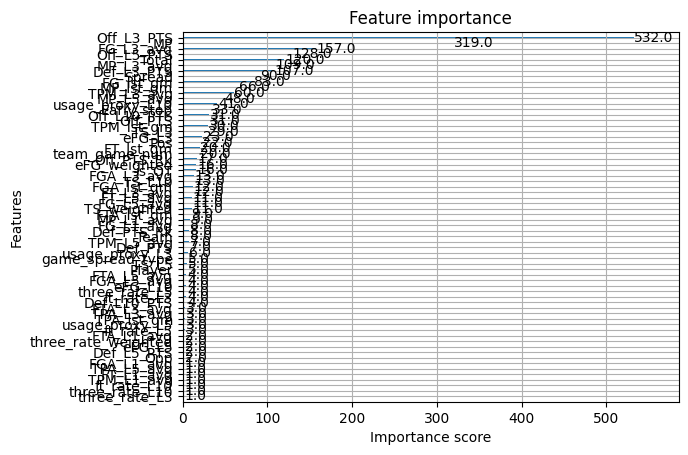

In [132]:
df_main = df[df.Season >= 2022].copy()
df_main = setup_df_main(df_main)
display(df_main)

n = len(df_main)
train_end = int(0.65 * n)
val_end   = int(0.85 * n)
main_train_df = df_main.iloc[:train_end]
main_val_df   = df_main.iloc[train_end:val_end]
main_test_df  = df_main.iloc[val_end:]
main_DFS = (main_train_df, main_val_df, main_test_df)

# stat_model = create_baseline_model(df_main, tgt_stat, main_DFS)
stat_model, stat_preds, y_test_stat, analyze_df_stat = hyperparam_tuning(main_DFS, tgt_stat, n_iter=1)
feature_importance(stat_model, df_main.columns.tolist())

# stat_model.save_model(f"../ML_models/{tgt_stat}_model.json")
# print(f'Saved {tgt_stat} model!')

In [ ]:
analyze_df_stat = main_test_df.drop([tgt_stat, f'{tgt_stat}_preds'], axis=1)\
                .merge(analyze_df_stat[['Date', 'Team', 'Player', tgt_stat, f'{tgt_stat}_preds']], on=['Date', 'Team', 'Player'])
analyze_df_stat['Diff'] = analyze_df_stat[tgt_stat] - analyze_df_stat[f'{tgt_stat}_preds']
analyze_df_stat['Diff2'] = abs(analyze_df_stat['Diff'])
analyze_df_stat.sort_values('Diff2', ascending=False).drop('Diff2', axis=1).head(15)
# display(analyze_df_stat[(analyze_df_stat.Date == '2026-01-04') & (analyze_df_stat.Team == 'LAL')])

In [133]:
rmse = np.sqrt(mean_squared_error(y_test_stat, stat_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_stat, stat_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.rename(columns={"TRB": "REB", "3PM": "TPM", "3PA": "TPA"})
df_gms['STL_BLK'] = df_gms.STL + df_gms.BLK
df_gms['PR'] = df_gms.PTS + df_gms.REB 
df_gms['PA'] = df_gms.PTS + df_gms.AST
df_gms['RA'] = df_gms.REB + df_gms.AST
df_gms['PRA'] = df_gms.PTS + df_gms.REB + df_gms.AST

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff2'] <= rmse, 1, 0)
# df_yesterday = df_yesterday[(abs(df_yesterday.Diff) > rmse)]
# df_yesterday = df_yesterday[df_yesterday.InRMSE_Range == 0]

print("Total Accuracy (ParlayHit):", ((df_yesterday.ParlayHit == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.ParlayHit == 1).sum(), "/", df_yesterday.shape[0])

print("\nTotal Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), "/", df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff', 'Diff2', 'Act_Res', 'Pred_Res'], axis=1).sort_values(f'{tgt_stat}_line', ascending=False)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[(df_yesterday.Team == tm)]) #  & (df_yesterday.ParlayHit == 1)
else:
    display(df_yesterday)

RMSE: 3.78152088029441
Total Accuracy (ParlayHit): 0.4175824175824176
38 / 91

Total Accuracy (InRMSE_Range): 0.4065934065934066
37 / 91


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
6,2026-01-04,LAL,Luka Doncic,PG,MEM,35.530140,38.88,35.5,29.425018,36,0,0
34,2026-01-04,LAL,LeBron James,SF,MEM,33.629990,37.28,23.5,20.777567,26,0,0
77,2026-01-04,LAL,Jake LaRavia,PF,MEM,30.311096,34.50,12.5,11.892099,26,0,0
38,2026-01-04,LAL,Deandre Ayton,C,MEM,28.420122,33.57,12.5,9.941256,15,0,0
62,2026-01-04,LAL,Marcus Smart,SG,MEM,29.761141,31.15,10.5,11.740422,6,0,0
67,2026-01-04,LAL,Jaxson Hayes,C,MEM,18.542831,14.43,6.5,7.534648,1,0,0
64,2026-01-04,LAL,Jarred Vanderbilt,PF,MEM,20.961756,21.95,5.5,6.630007,7,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
42,2026-01-04,OKC,Shai Gilgeous-Alexander,PG,PHO,33.915668,35.65,31.5,29.364738,25,1,0
22,2026-01-04,OKC,Jalen Williams,SG,PHO,28.511902,34.48,17.5,14.320476,23,0,0
23,2026-01-04,OKC,Chet Holmgren,PF,PHO,29.873045,32.60,16.5,19.569561,18,1,1
56,2026-01-04,OKC,Ajay Mitchell,SG,PHO,26.103598,27.20,12.5,13.827897,13,1,1
89,2026-01-04,OKC,Aaron Wiggins,SG,PHO,21.226280,19.28,9.5,9.222972,5,1,0
48,2026-01-04,OKC,Cason Wallace,SG,PHO,26.628942,17.85,7.5,9.163237,3,0,0
84,2026-01-04,OKC,Luguentz Dort,SF,PHO,27.252378,26.52,6.5,6.818851,13,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
24,2026-01-04,MIN,Anthony Edwards,SG,WAS,35.905300,30.17,30.5,27.475674,35,0,0
60,2026-01-04,MIN,Julius Randle,PF,WAS,34.265678,25.30,21.5,22.794731,22,1,1
5,2026-01-04,MIN,Naz Reid,C,WAS,27.860161,20.12,14.5,20.678717,9,0,0
35,2026-01-04,MIN,Jaden McDaniels,PF,WAS,30.098097,21.88,13.5,10.793336,12,1,1
32,2026-01-04,MIN,Donte DiVincenzo,SG,WAS,30.702559,22.58,12.5,9.702487,5,1,0
50,2026-01-04,MIN,Rudy Gobert,C,WAS,31.641565,29.32,11.5,9.926951,18,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
1,2026-01-04,MIL,Giannis Antetokounmpo,PF,SAC,28.480701,31.62,29.5,19.889799,37,0,0
26,2026-01-04,MIL,Kevin Porter Jr.,PG,SAC,36.455505,39.73,17.5,14.562097,25,0,0
61,2026-01-04,MIL,Ryan Rollins,PG,SAC,31.941858,33.87,15.5,16.771965,12,0,0
70,2026-01-04,MIL,Bobby Portis,PF,SAC,23.641373,16.08,12.5,13.472248,9,0,0
86,2026-01-04,MIL,Kyle Kuzma,PF,SAC,29.801361,17.72,11.5,11.791162,3,0,0
4,2026-01-04,MIL,Myles Turner,C,SAC,27.853252,31.92,10.5,16.727028,15,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
51,2026-01-04,CLE,Donovan Mitchell,SG,DET,34.247589,33.08,28.5,26.935966,30,0,1
79,2026-01-04,CLE,Darius Garland,PG,DET,32.487499,32.13,17.5,17.983263,16,0,1
13,2026-01-04,CLE,Evan Mobley,PF,DET,31.198790,32.75,16.5,12.340613,15,1,1
40,2026-01-04,CLE,De'Andre Hunter,SF,DET,26.888300,24.10,13.5,11.228312,14,0,1
45,2026-01-04,CLE,Jaylon Tyson,SG,DET,27.216845,25.27,12.5,14.310860,6,0,0
0,2026-01-04,CLE,Sam Merrill,SG,DET,23.550919,27.25,9.5,19.787407,15,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
74,2026-01-04,BRK,Michael Porter Jr.,SF,DEN,31.644651,32.07,27.5,28.281786,27,0,1
8,2026-01-04,BRK,Day'Ron Sharpe,C,DEN,19.745663,32.10,12.5,7.480959,17,0,0
33,2026-01-04,BRK,Noah Clowney,PF,DEN,29.960150,29.12,11.5,8.722165,22,0,0
72,2026-01-04,BRK,Terance Mann,SG,DEN,26.127554,26.03,6.5,5.605024,6,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
59,2026-01-04,DET,Cade Cunningham,PG,CLE,35.431683,37.03,27.5,26.194145,27,1,1
21,2026-01-04,DET,Isaiah Stewart,C,CLE,24.026945,31.47,12.5,9.241933,8,1,1
30,2026-01-04,DET,Ausar Thompson,SF,CLE,27.259537,21.72,12.5,9.685979,8,1,1
18,2026-01-04,DET,Marcus Sasser,PG,CLE,12.129115,3.00,11.5,8.022791,0,1,0
15,2026-01-04,DET,Duncan Robinson,SF,CLE,26.208231,29.52,11.5,7.552246,12,0,0
29,2026-01-04,DET,Jaden Ivey,SG,CLE,19.048105,19.23,10.5,7.656539,7,1,1
58,2026-01-04,DET,Javonte Green,SG,CLE,21.515100,24.02,9.5,8.178356,11,0,1
12,2026-01-04,DET,Paul Reed,C,CLE,7.860435,30.13,7.5,3.236338,8,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
10,2026-01-04,ORL,Paolo Banchero,PF,IND,36.149956,36.15,25.5,20.933544,28,0,0
20,2026-01-04,ORL,Desmond Bane,SG,IND,34.898941,36.55,21.5,18.231533,31,0,0
7,2026-01-04,ORL,Anthony Black,PG,IND,34.568218,35.55,19.5,24.523800,27,1,1
75,2026-01-04,ORL,Wendell Carter Jr.,C,IND,31.493427,31.52,12.5,11.791741,18,0,0
82,2026-01-04,ORL,Goga Bitadze,C,IND,16.001284,16.48,6.5,6.935958,2,0,0
90,2026-01-04,ORL,Tyus Jones,PG,IND,20.738050,13.92,6.5,6.234659,3,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
63,2026-01-04,DEN,Jamal Murray,PG,BRK,36.312431,39.73,25.5,24.317053,27,0,1
68,2026-01-04,DEN,Peyton Watson,SF,BRK,32.882156,28.62,14.5,13.504377,23,0,0
43,2026-01-04,DEN,Aaron Gordon,PF,BRK,23.628725,21.23,12.5,10.482591,20,0,0
2,2026-01-04,DEN,Christian Braun,SG,BRK,27.538017,24.20,11.5,3.507168,3,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
81,2026-01-04,IND,Pascal Siakam,PF,ORL,33.805614,36.45,24.5,24.953512,34,1,0
36,2026-01-04,IND,Andrew Nembhard,PG,ORL,33.359459,35.48,18.5,15.796778,20,0,0
39,2026-01-04,IND,Aaron Nesmith,SF,ORL,29.206600,34.13,13.5,10.986235,25,0,0
88,2026-01-04,IND,T.J. McConnell,PG,ORL,17.348101,20.80,9.5,9.783926,10,1,1
85,2026-01-04,IND,Jay Huff,C,ORL,18.345234,17.23,7.5,7.204438,11,0,0
49,2026-01-04,IND,Ben Sheppard,SG,ORL,20.102419,24.35,6.5,8.107225,8,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
19,2026-01-04,NOP,Zion Williamson,PF,MIA,30.150599,26.22,24.5,27.965334,12,0,0
53,2026-01-04,NOP,Trey Murphy III,SF,MIA,29.734610,38.20,20.5,19.046286,27,0,0
17,2026-01-04,NOP,Jordan Poole,PG,MIA,27.910013,24.60,16.5,20.284595,8,0,0
46,2026-01-04,NOP,Jeremiah Fears,PG,MIA,27.707008,26.12,12.5,10.783546,21,0,0
47,2026-01-04,NOP,Derik Queen,C,MIA,24.684788,29.62,12.5,14.184892,13,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
78,2026-01-04,MIA,Norman Powell,SG,NOP,32.088047,28.78,24.5,25.039686,34,1,0
52,2026-01-04,MIA,Andrew Wiggins,SF,NOP,32.401409,28.35,17.5,15.987735,10,1,0
14,2026-01-04,MIA,Bam Adebayo,C,NOP,32.584702,28.78,17.5,13.382139,12,1,1
31,2026-01-04,MIA,Kel'el Ware,C,NOP,28.454071,24.63,13.5,16.310551,16,1,1
71,2026-01-04,MIA,Davion Mitchell,PG,NOP,31.737719,29.32,9.5,8.574310,9,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
27,2026-01-04,PHO,Devin Booker,SG,OKC,31.549294,38.18,23.5,26.403870,24,1,1
91,2026-01-04,PHO,Dillon Brooks,SF,OKC,30.011669,33.55,18.5,18.548943,22,1,1
16,2026-01-04,PHO,Collin Gillespie,PG,OKC,30.880175,25.87,13.5,17.313433,8,0,0
44,2026-01-04,PHO,Mark Williams,C,OKC,22.033995,21.28,10.5,12.469675,8,0,0
66,2026-01-04,PHO,Royce O'Neale,SF,OKC,29.493750,31.52,8.5,9.541388,3,0,0
65,2026-01-04,PHO,Oso Ighodaro,PF,OKC,22.144987,23.63,5.5,6.582074,5,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
9,2026-01-04,MEM,Jaren Jackson Jr.,C,LAL,33.197258,33.68,20.5,25.275604,14,0,0
25,2026-01-04,MEM,Santi Aldama,PF,LAL,33.054234,30.73,14.5,17.464043,12,0,0
11,2026-01-04,MEM,Cedric Coward,SG,LAL,27.743280,12.55,14.5,18.929033,16,1,1
37,2026-01-04,MEM,Jaylen Wells,SG,LAL,30.453861,24.50,13.5,10.864161,23,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
83,2026-01-04,SAC,DeMar DeRozan,PF,MIL,34.672501,28.72,19.5,19.174313,11,1,0
3,2026-01-04,SAC,Zach LaVine,SG,MIL,28.486666,35.53,16.5,23.567083,20,1,1
54,2026-01-04,SAC,Keegan Murray,PF,MIL,34.168648,26.72,15.5,14.087653,12,1,1
69,2026-01-04,SAC,Russell Westbrook,PG,MIL,28.383686,37.90,14.5,13.521154,21,0,0
87,2026-01-04,SAC,Maxime Raynaud,C,MIL,28.879982,24.13,12.5,12.215854,6,1,0
92,2026-01-04,SAC,Dennis Schroder,PG,MIL,26.608156,26.12,11.5,11.510719,13,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
76,2026-01-04,WAS,CJ McCollum,SG,MIN,31.834545,22.17,18.5,17.792765,20,0,1
55,2026-01-04,WAS,Tre Johnson,SG,MIN,24.575035,26.97,14.5,15.864750,13,0,1
41,2026-01-04,WAS,Bilal Coulibaly,SG,MIN,28.367390,27.57,10.5,12.715169,6,0,0
80,2026-01-04,WAS,Khris Middleton,SF,MIN,22.410961,17.85,9.5,9.033706,10,0,1
57,2026-01-04,WAS,Justin Champagnie,SF,MIN,24.012918,18.15,9.5,10.825013,6,0,0


### Today's predictions

In [103]:
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

# Predict Mins
df_lines["Team"] = team_encoder.transform(df_lines["Team"])
df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_pred_mins = setup_df_mins(con, df_pred)
df_pred_mins = df_pred_mins.drop(['Date', 'MP'], axis=1)
DM_mins = xgb.DMatrix(df_pred_mins)
df_pred['MP'] = mins_model.predict(DM_mins)

# Predict Stat
df_pred = setup_df_main(df_pred)
feature_cols = [col for col in df_pred.columns if col not in ['Date', tgt_stat]]
df_pred = df_pred[df_pred.Date == now][feature_cols]
DM_stats = xgb.DMatrix(df_pred)
df_pred[f"{tgt_stat}_proj"] = stat_model.predict(DM_stats)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_lines['Team'] = team_encoder.inverse_transform(df_lines["Team"])
df_pred['Opp'] = team_encoder.inverse_transform(df_pred["Opp"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])
df_pred['Pos'] = position_encoder.inverse_transform(df_pred["Pos"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

tds_picks = df_pred[~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', 'Pos', 'Opp', 'MP', 'MP_L5_avg', f'{tgt_stat}_line', f'{tgt_stat}_proj']]
tds_picks['Diff'] = abs((df_pred[f'{tgt_stat}_line'] - df_pred[f'{tgt_stat}_proj']))
tds_picks['Diff2'] = abs((df_pred['MP'] - df_pred['MP_L5_avg']))
tds_picks = tds_picks.sort_values('Diff', ascending=False).drop(['Diff', 'Diff2'], axis=1)
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)
tds_picks.insert(0, 'Date', pd.to_datetime(now))
# partition_save_df(tds_picks, f"../tables/2025/gmday_preds_{tgt_stat}.csv")

82 rows


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
45,DEN,Jalen Pickett,SG,PHI,17.830132,15.620872,21.5,8.823349
39,DEN,Bruce Brown,SG,PHI,26.493326,28.232389,21.5,13.415150
62,DEN,Peyton Watson,SF,PHI,31.767128,31.826196,27.5,21.110466


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
95,ATL,Onyeka Okongwu,C,TOR,33.732769,33.316996,25.5,33.371597
90,ATL,Kristaps Porzingis,C,TOR,24.564474,25.540648,19.5,23.711779
34,ATL,Dyson Daniels,SG,TOR,35.880405,34.205354,25.5,27.936462
55,ATL,Jalen Johnson,SF,TOR,37.303173,35.196374,42.5,44.661598
19,ATL,Nickeil Alexander-Walker,SG,TOR,36.805080,32.887693,26.5,28.005789


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
61,CHO,Kon Knueppel,SF,OKC,31.779238,29.254718,24.5,31.465038
58,CHO,Brandon Miller,SF,OKC,34.332958,34.114358,25.5,31.065107
7,CHO,LaMelo Ball,PG,OKC,28.573132,28.570298,27.5,29.745478
76,CHO,Miles Bridges,PF,OKC,32.114906,29.677419,26.5,27.202248


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
2,UTA,Keyonte George,PG,POR,37.035725,35.955087,35.5,42.291420
98,UTA,Jusuf Nurkic,C,POR,30.478291,28.971178,25.5,30.591208
68,UTA,Brice Sensabaugh,SF,POR,28.601999,25.834146,20.5,19.240046
67,UTA,Ace Bailey,SF,POR,23.572960,23.852504,15.5,16.246525
72,UTA,Lauri Markkanen,PF,POR,37.344360,35.105823,35.5,34.847538


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
91,NYK,Karl-Anthony Towns,C,DET,30.667564,29.146709,35.5,42.233070
78,NYK,OG Anunoby,PF,DET,36.864723,35.544886,24.5,26.332912
53,NYK,Mikal Bridges,SF,DET,38.240517,37.744552,23.5,24.623436
4,NYK,Jalen Brunson,PG,DET,37.563221,37.937889,39.5,38.641953
107,NYK,Mitchell Robinson,C,DET,19.781330,21.030497,14.5,15.028715
31,NYK,Miles McBride,SG,DET,30.480955,26.006059,17.5,17.888865


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
13,PHO,Collin Gillespie,PG,HOU,31.231823,31.515736,20.5,27.228882
64,PHO,Royce O'Neale,SF,HOU,31.386765,28.911828,14.5,16.788021
22,PHO,Devin Booker,SG,HOU,35.287872,32.676270,32.5,33.771278
52,PHO,Dillon Brooks,SF,HOU,33.141930,31.075168,24.5,24.033957
30,PHO,Grayson Allen,SG,HOU,30.685247,27.800601,17.5,17.947548


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
56,LAC,Kawhi Leonard,SF,GSW,37.362389,33.026926,40.5,47.105980
1,LAC,James Harden,PG,GSW,36.101921,32.859771,37.5,32.823494
10,LAC,Kris Dunn,PG,GSW,29.828587,27.330919,15.5,13.283035
92,LAC,Ivica Zubac,C,GSW,25.646679,27.458994,26.5,25.878899


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
0,OKC,Shai Gilgeous-Alexander,PG,CHO,33.019539,31.836507,42.5,36.563736
24,OKC,Jalen Williams,SG,CHO,29.930431,28.940967,29.5,25.775244
38,OKC,Isaiah Joe,SG,CHO,17.620575,15.876873,11.5,8.216751
36,OKC,Aaron Wiggins,SG,CHO,20.453995,17.937507,14.5,11.666113
71,OKC,Chet Holmgren,PF,CHO,29.076250,27.359231,27.5,29.911034
41,OKC,Cason Wallace,SG,CHO,26.005262,24.084289,12.5,10.440504
29,OKC,Ajay Mitchell,SG,CHO,26.487288,25.258775,19.5,19.578527


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
63,CHI,Kevin Huerter,SF,BOS,26.709278,23.634586,18.5,23.150841
26,CHI,Coby White,SG,BOS,27.678589,27.574418,25.5,21.365337
32,CHI,Ayo Dosunmu,SG,BOS,27.630743,26.139415,19.5,22.682817
79,CHI,Matas Buzelis,PF,BOS,30.816740,26.440177,23.5,26.506985
42,CHI,Isaac Okoro,SG,BOS,26.759151,23.432387,13.5,15.748034
89,CHI,Nikola Vucevic,C,BOS,33.263718,29.489880,30.5,31.795330


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
6,PHI,Tyrese Maxey,PG,DEN,37.333328,38.488330,38.5,42.763103
25,PHI,Quentin Grimes,SG,DEN,32.033752,31.885822,19.5,17.760992
21,PHI,VJ Edgecombe,SG,DEN,36.827892,35.324821,25.5,27.196150
88,PHI,Joel Embiid,C,DEN,32.385418,32.731250,37.5,36.105354
73,PHI,Paul George,PF,DEN,33.919853,33.078319,24.5,24.297493


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
60,DET,Ausar Thompson,SF,NYK,27.169508,23.963052,20.5,16.390701
5,DET,Cade Cunningham,PG,NYK,36.912365,34.739734,43.5,46.687416
59,DET,Duncan Robinson,SF,NYK,28.667664,28.151786,15.5,13.434010


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
18,POR,Shaedon Sharpe,SG,UTA,32.302971,32.123663,31.5,27.689346
96,POR,Donovan Clingan,C,UTA,31.948643,27.377035,25.5,28.446278
75,POR,Toumani Camara,PF,UTA,35.880798,33.654902,22.5,20.124338
50,POR,Deni Avdija,SF,UTA,38.066357,36.386845,46.5,45.052727


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
93,BOS,Neemias Queta,C,CHI,26.609211,26.801422,19.5,16.614321
3,BOS,Payton Pritchard,PG,CHI,36.260178,33.362094,26.5,28.026848
33,BOS,Anfernee Simons,SG,CHI,27.042053,26.166985,17.5,19.017912
47,BOS,Jaylen Brown,SF,CHI,34.053921,31.232490,43.5,42.029396
27,BOS,Derrick White,SG,CHI,36.643425,33.861604,29.5,30.461769
100,BOS,Luka Garza,C,CHI,19.898878,20.056258,16.5,16.112638


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
104,GSW,Al Horford,C,LAC,17.321609,14.747815,10.5,13.207706
48,GSW,Jimmy Butler,SF,LAC,34.309845,33.194373,29.5,32.038586
23,GSW,Brandin Podziemski,SG,LAC,27.479591,28.489209,17.5,19.409775
84,GSW,Draymond Green,PF,LAC,25.760208,25.098565,18.5,20.186064
28,GSW,Moses Moody,SG,LAC,23.189508,21.930199,13.5,12.038694
8,GSW,Stephen Curry,PG,LAC,35.246368,33.932947,35.5,34.965370
85,GSW,Quinten Post,PF,LAC,20.127733,17.659517,12.5,12.152355


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
74,TOR,Scottie Barnes,PF,ATL,36.575981,35.939593,34.5,36.709145
83,TOR,Collin Murray-Boyles,PF,ATL,23.698666,21.419556,16.5,18.014788
97,TOR,Sandro Mamukelashvili,C,ATL,26.919415,23.009678,19.5,20.427076
54,TOR,RJ Barrett,SF,ATL,28.504065,29.734034,27.5,26.820726
9,TOR,Immanuel Quickley,PG,ATL,33.950584,33.539295,26.5,25.938889
49,TOR,Brandon Ingram,SF,ATL,36.929260,35.712334,33.5,33.215500
14,TOR,Jamal Shead,PG,ATL,21.559278,23.706116,13.5,13.550097


,Team,Player,Pos,Opp,MP,MP_L5_avg,PRA_line,PRA_proj
77,HOU,Jabari Smith Jr.,PF,PHO,35.828270,33.695298,24.5,25.273315
11,HOU,Reed Sheppard,PG,PHO,27.741827,25.462709,19.5,18.778126
57,HOU,Amen Thompson,SF,PHO,36.140839,34.421069,32.5,32.002739
82,HOU,Tari Eason,PF,PHO,27.081703,21.591313,22.5,22.961140
51,HOU,Kevin Durant,SF,PHO,36.875137,34.458496,38.5,38.100327
